<a href="https://www.kaggle.com/tuankiennguyen/brain-segmentation-with-pytorch?scriptVersionId=86141649" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install torchio

     |████████████████████████████████| 164 kB 893 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [2]:
import time
import tqdm
import os
import argparse
import logging
import sys
import wandb
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

import nibabel as nib
import torchio as tio
import tempfile

import torch
import torch.nn as nn
from torch.nn.functional import pad, sigmoid, binary_cross_entropy
from torch.utils.data import DataLoader, Dataset
 
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

import sklearn 
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

%matplotlib inline

# **Visualize Data Image**

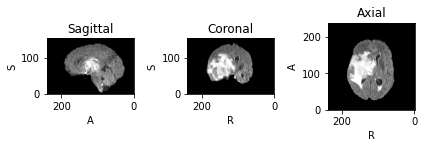

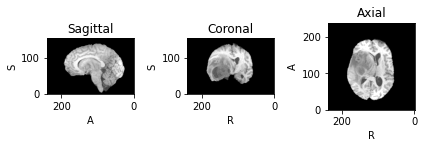

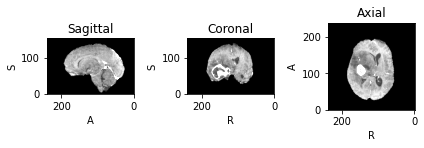

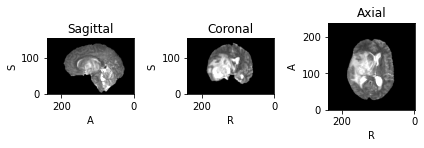

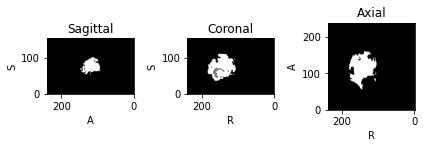

In [3]:
flair_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
t1_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'
t1ce_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii'
t2_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii'
seg_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii'


flair_img = tio.ScalarImage(flair_path)
t1_img = tio.ScalarImage(t1_path)
t1ce_img = tio.ScalarImage(t1ce_path)
t2_img = tio.ScalarImage(t2_path)
seg_img = tio.ScalarImage(seg_path)

flair_img.plot()
t1_img.plot()
t1ce_img.plot()
t2_img.plot()
seg_img.plot()

# **Preprocess Dataset and Clean Data**

In [4]:
"""
Create class function for target path and seed random
"""
class GlobalConfig():
    root = '../input/brats20-dataset-training-validation/'
    train_path = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
    val_path = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'
    name_mapping_path = 'name_mapping.csv'
    survival_info_path = 'survival_info.csv'
    train_df = 'train_df.csv'
    seed = 55
def SeedEveryThing(seed:int):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
config = GlobalConfig()
SeedEveryThing(config.seed)

In [5]:
"""
In this dataset of MICCAI_BraTS2020, it has two data files CSV so we need to
merge them into one data frame to visualize and remove null data 
"""

name_mapping = pd.read_csv(os.path.join(config.root, config.train_path + config.name_mapping_path))
survival_info = pd.read_csv(os.path.join(config.root, config.train_path + config.survival_info_path))
name_mapping.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis = 1, inplace = True)
df = survival_info.merge(name_mapping, on='Brats20ID', how='right')
path = []
for _, row in df.iterrows():
    id_ = row['Brats20ID']
    phase = id_.split('_')[-2]
    if phase == 'Training':
        data_path = os.path.join(config.root, config.train_path + id_)
    else:
        data_path = os.path.join(config.root, config.train_path + id_)
    path.append(data_path)
df['Path'] = path
df['Age_rank'] = df['Age'].values//10*10
df= df.loc[df['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop = True)
train_df = df.loc[df['Age'].isnull() != True].reset_index(drop = True)
skf = StratifiedKFold(n_splits=7, random_state=config.seed, shuffle = True)
for i, (train_index, val_index) in enumerate(skf.split(train_df, train_df['Age_rank'])):
    train_df.loc[val_index,['Fold']] = i
train_data = train_df.loc[train_df['Fold'] != 0.0].reset_index(drop=True)
val_data = train_df.loc[train_df['Fold'] == 0.0].reset_index(drop=True)
test_df = df.loc[df['Age'].isnull()].reset_index(drop=True)
train_df.to_csv(config.train_df, index = False)
train_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in floor_divide
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)


,Brats20ID,Age,Survival_days,Extent_of_Resection,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,Path,Age_rank,Fold
0,BraTS20_Training_001,60.463,289,GTR,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,../input/brats20-dataset-training-validation/B...,60.0,1.0
1,BraTS20_Training_002,52.263,616,GTR,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,../input/brats20-dataset-training-validation/B...,50.0,3.0
2,BraTS20_Training_003,54.301,464,GTR,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,../input/brats20-dataset-training-validation/B...,50.0,0.0
3,BraTS20_Training_004,39.068,788,GTR,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,../input/brats20-dataset-training-validation/B...,30.0,3.0
4,BraTS20_Training_005,68.493,465,GTR,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,../input/brats20-dataset-training-validation/B...,60.0,0.0


In [6]:
# List transform
def transforms(phase):
    list_transform = {
    tio.RandomBiasField()
    }
    if phase == 'train':
        transform = tio.Compose([
            tio.OneOf(list_transform, p=0.5),
            tio.RandomFlip(('LR',)),
            tio.ToCanonical(p=0.5)
        ])
    else:
        transform = tio.Compose([
        ])
    return transform

# **Create Brats Dataset function**

In [7]:
class BratsDataSet(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str = 'test'):
        self.df = df
        self.phase = phase
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, index):
        id_ = self.df.loc[index, 'Brats20ID']
        data_path = self.df.loc[self.df['Brats20ID'] == id_]['Path'].values[0]
        data_img = []
        resample = tio.Resample((2.5,2.5,1))
        crop = tio.CropOrPad((180, 180, 155))
        for data_type in self.data_types:
            img = tio.ScalarImage(os.path.join(data_path,id_ + data_type)) #data_img shape (1, 240, 240, 155)
            img = crop(img)
            img = resample(img) 
            img = np.asarray(img) # img shape (1, 72, 72, 72)
            img = np.squeeze(img, axis = 0)
            img = self.Normalize(img)
            data_img.append(img)
        image_stack = np.stack(data_img) # data shape = [4, 72, 72, 72]
        image_stack = np.moveaxis(image_stack, (0,1,2,3), (0,3,2,1))
        image_stack = torch.Tensor(image_stack)
        if phase != 'test':
            label = tio.ScalarImage(os.path.join(data_path, id_ + '_seg.nii'))
            label = crop(label)
            label = resample(label)
            label = np.asarray(label)
            label = np.squeeze(label, 0)
            label_stack = self.ConvertToMultiChannel(label)
            label_stack = torch.Tensor(label_stack)
            return {
                'ID': id_,
                'image':image_stack,
                'label':label_stack
            }
        return{
            'ID': id_,
            'image': image_stack
        }
    def Normalize(self, image):
        return (image - np.min(image))/(np.max(image) - np.min(image))
                
    def ConvertToMultiChannel(self, label):
        '''
        Convert labels to multi channels based on brats classes:
        label 1 is the peritumoral edema
        label 2 is the GD-enhancing tumor
        label 3 is the necrotic and non-enhancing tumor core
        The possible classes are TC (Tumor core), WT (Whole tumor)
        and ET (Enhancing tumor)
        '''
        label_TC = label.copy()
        label_TC[label_TC == 1] = 1
        label_TC[label_TC == 2] = 0
        label_TC[label_TC == 4] = 1
        
        label_WT = label.copy()
        label_WT[label_WT == 1] = 1
        label_WT[label_WT == 2] = 1
        label_WT[label_WT == 4] = 1
        
        label_ET = label.copy()
        label_ET[label_ET == 1] = 0
        label_ET[label_ET == 2] = 0
        label_ET[label_ET == 4] = 1
        
        label_stack = np.stack([label_WT, label_TC, label_ET])
        label_stack = np.moveaxis(label_stack, (0,1,2,3), (0,3,2,1))
        return label_stack
    
data = BratsDataSet(train_data,'train')

In [8]:
def get_dataloader(dataset, path_to_csv, phase, fold = 0, batch_size = 1, num_workers = 4, transform = None):
    """
    This  function is saving image data in to the list and putting it with torchio.SubjectDataSet
    to split and transform image
    """
    
    start_time = time.time()
    data = pd.read_csv(path_to_csv)
    train_data = data.loc[data['Fold'] != fold].reset_index(drop = True)
    val_data = data.loc[data['Fold'] == fold].reset_index(drop = True)
    if phase == 'train':
        data = train_data
    else:
        data = val_data
    data_set = dataset(data, phase)
    list_subjects = []
    count = 0
    for i in range(len(data_set)):
        loop_time = time.time()
        id_ = data_set[i]['ID']
        image = data_set[i]['image']
        label = data_set[i]['label']
        subject = tio.Subject(
            image = tio.ScalarImage(tensor = image),
            label = tio.LabelMap(tensor = label)
        )
        list_subjects.append(subject)
    if transform != None:
        subject_dataset = tio.SubjectsDataset(list_subjects, transform=transform)
        data_loader = DataLoader(subject_dataset,
                                 batch_size=batch_size,
                                 num_workers=num_workers
                                )
        print('Finished transform')
    return data_loader

In [9]:
# train_loader = get_dataloader(BratsDataSet,
#                                   config.train_df,
#                                   phase = 'train',
#                                   fold = 0,
#                                   batch_size = 1,
#                                   num_workers = 4,
#                                   transform = transforms('train')
#                                  )

In [10]:
# val_loader = get_dataloader(BratsDataSet,
#                             config.train_df,
#                             phase = 'val',
#                             fold = 0,
#                             batch_size = 1,
#                             num_workers = 4,
#                             transform =val_transform
#                             )
# print(len(val_loader))

In [11]:
# for data in train_loader:
#     image = data['image'][tio.DATA]
#     label = data['label'][tio.DATA]
#     break

In [12]:
# image.size(), label.size()

# **Dice Loss**

The Dice coefficient, or Dice-Sørensen coefficient, is a common metric for pixel segmentation that can also be modified to act as a loss function:

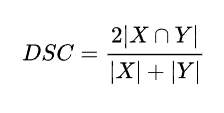


In [13]:
class DiceLoss(nn.Module):
    def __init__(self, weight = None, size_average = True):
        super(DiceLoss, self).__init__()
    def forward(self, inputs, targets, smooth = 1):
        # Commnent out if your model contains a sigmoid or equivalent activation layer
        inputs = sigmoid(inputs)
        
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs*targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum()+ targets.sum() + smooth)
        return 1 - dice

# **BCE-Dice Loss**

This loss combines Dice loss with the standard binary cross-entropy (BCE) loss that is generally the default for segmentation models. Combining the two methods allows for some diversity in the loss, while benefitting from the stability of BCE. The equation for multi-class BCE by itself will be familiar to anyone who has studied logistic regression:

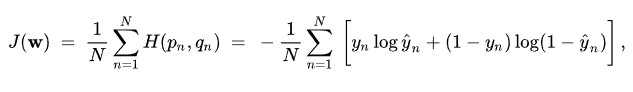

In [14]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight = None, size_average = True):
        super(DiceBCELoss, self).__init__()
    def forward(self, inputs, targets, smooth = 1):
        # comment out if your model contains a sigmoid or equivalent activation layer
        inputs = sigmoid(inputs)
        
        # flatten label and predict tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs*targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = binary_cross_entropy(inputs, targets, reduction = 'mean')
        Dice_BCE = BCE + dice_loss
        return Dice_BCE
    

# **Jaccard/Intersection over Union (IoU) Loss**

The IoU metric, or Jaccard Index, is similar to the Dice metric and is calculated as the ratio between the overlap of the positive instances between two sets, and their mutual combined values:
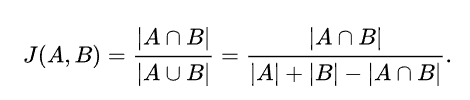

Like the Dice metric, it is a common means of evaluating the performance of pixel segmentation models.


In [15]:
class IoU(nn.Module):
    def __init__(self, weight = None, size_average = True):
        super(IoU, self).__init__()
    def forward(self, inputs, target, smooth = 1):
        inputs = sigmoid(inputs)
        
        # Flatten labels and predict
        inputs = inputs.view(-1)
        target = target.view(-1)
        
        interection = (inputs*target).sum()
        total = (inputs + target).sum()
        union = total - interection
        
        IoU = (interection + smooth)/ (union + smooth)
        return 1 - IoU
    

# **UNET 3D**

In [16]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        x = self.double_conv(x)
        return x

In [17]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        x = self.encoder(x)
        return x

In [18]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels//2, out_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Make sure size data when you combine are the same size
        diffX = x2.size()[4] - x1.size()[4]
        diffY = x2.size()[3] - x1.size()[3]
        diffZ = x2.size()[2] - x1.size()[2]
        
        x1 = torch.nn.functional.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [19]:
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.out_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.out_conv(x)

In [20]:
'''
                            UNET 3D
        1|->|->|---------------------------->|->|->|1

              2|->|->|---------------->|->|->|2

                    3|->|->|---->|->|->|3     

                          4|->|->|4
'''
class UNET3D(nn.Module):
    def __init__(self, in_channels, out_channels, n_classes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_classes = n_classes
        
        self.double_conv = DoubleConv(self.in_channels, self.out_channels)
        # encoder downsamplers
        self.down_1 = Down(self.out_channels, self.out_channels*2)
        self.down_2 = Down(self.out_channels*2, self.out_channels*4)
        self.down_3 = Down(self.out_channels*4, self.out_channels*8)
        self.down_4 = Down(self.out_channels*8, self.out_channels*8)

        # decoder upsamplers
        self.up_4 = Up(self.out_channels*16, self.out_channels*4)
        self.up_3 = Up(self.out_channels*8, self.out_channels*2)
        self.up_2 = Up(self.out_channels*4, self.out_channels)
        self.up_1 = Up(self.out_channels*2, self.out_channels)

        # output
        self.out = Out(self.out_channels, self.n_classes)
    def forward(self, x):
        en_1 = self.double_conv(x)
        en_2 = self.down_1(en_1)
        en_3 = self.down_2(en_2)
        en_4 = self.down_3(en_3)
        en_5 = self.down_4(en_4)
        
        de_4 = self.up_4(en_5, en_4)
        de_3 = self.up_3(de_4, en_3)
        de_2 = self.up_2(de_3, en_2)
        de_1 = self.up_1(de_2, en_1)
        
        out = self.out(de_1)
        return out

# **Training**

In [21]:
def training(model,
             device,
             dataset,
             path_to_csv,
             epochs: int = 4,
             batch_size: int= 1,
             lr: float = 1e-4,
             save_checkpoint: bool = True,
             amp: bool = False
            ):
    # 1.Create dataloader
    phase = ['train', 'val']
    time_loader = time.time()
    train_loader = get_dataloader(dataset = dataset,
                                  path_to_csv = path_to_csv,
                                  phase = phase[0],
                                  fold = 0,
                                  batch_size = batch_size,
                                  num_workers = 4,
                                  transform = transforms('train')
                                 )
    
    val_loader = get_dataloader(dataset = dataset,
                                path_to_csv = path_to_csv,
                                phase = phase[1],
                                fold = 0,
                                batch_size = batch_size,
                                num_workers = 4,
                                transform = transforms('val')
                               )
    print(f'Total time for loader: {time.time() - time_loader}')
    
    # 2.Setup criterion and optimizer
    criterion = nn.BCEWithLogitsLoss()
    dice = DiceLoss()
    iou = IoU()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    global_step = 0
    
    # 4. Start training
    train_losses = []
    val_losses = []
    
    train_dice = []
    val_dice = []
    
    train_iou = []
    val_iou = []
    for epoch in range(epochs):
        with tqdm.tqdm(total = len(train_loader), desc = f'Epoch {epoch + 1}', unit='img') as pbar:
            model.train()
            train_loss = 0.0
            dice_pred = 0.0
            iou_pred = 0.0
            count = 0
            for i, data in enumerate(train_loader):
                count += 1
                image = data['image'][tio.DATA]
                true_mask = data['label'][tio.DATA]
                image = image.to(device)
                true_mask = true_mask.to(device)
                optimizer.zero_grad()
                
                with torch.cuda.amp.autocast(enabled=amp):
                    mask_pred = model(image)
                    loss = criterion(mask_pred, true_mask)
                    dice_check = dice(mask_pred, true_mask)
                    iou_check = iou(mask_pred, true_mask)
                optimizer.zero_grad()
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()
                
                pbar.update(image.shape[0])
                train_loss += loss.item()
                dice_pred += dice_check.item()
                iou_pred += iou_check.item()
                pbar.set_postfix(**{'loss (batch)': loss.item()})
                
            train_losses.append(train_loss/len(train_loader))
            train_dice.append(dice_pred/len(train_loader))
            train_iou.append(iou_pred/len(train_loader))
            
            if save_checkpoint:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'loss': loss,
                }, 'check_point_epoch_{}'.format(epoch))
                print('Saved check point')
                
        print(f'Train Epoch: {epoch+1} Loss: {train_loss/len(train_loader):.2f}, Dice ccuracy: {dice_pred/len(train_loader):.2f} IoU ccuracy: {iou_pred/len(train_loader):.2f}')
        with torch.no_grad():
            model.eval()
            val_loss = 0.0
            dice_pred = 0.0
            iou_pred = 0.0
            count = 0
            for i, data in enumerate(val_loader):
                count += 1
                image = data['image'][tio.DATA]
                true_mask = data['label'][tio.DATA]
                image = image.to(device)
                true_mask = true_mask.to(device)
                optimizer.zero_grad()
                
                with torch.cuda.amp.autocast(enabled=amp):
                    mask_pred = model(image)
                    loss = criterion(mask_pred, true_mask)
                    dice_check = dice(mask_pred, true_mask)
                    iou_check = iou(mask_pred, true_mask)
                
                pbar.update(image.shape[0])
                val_loss += loss.item()
                dice_pred += dice_check.item()
                iou_pred += iou_check.item()
                pbar.set_postfix(**{'loss (batch)': loss.item()})
                
        val_losses.append(val_loss/(len(val_loader)))
        val_dice.append(dice_pred/len(val_loader))
        val_iou.append(iou_pred/len(val_loader))
        print(f'Val Epoch: {epoch+1} loss: {val_loss/len(val_loader):.2f} Dice accuracy: {dice_pred/len(val_loader):.2f} IoU ccuracy: {iou_pred/len(val_loader):.2f}')
    
    losses = {'train': train_losses,
              'val': val_losses
             }
    dice_list = {'train':train_dice,
                 'val': val_dice
                }
    IoU_list = {'train': train_iou,
                'val': val_iou
               }
    data_pred = [losses, dice_list, IoU_list]
    fig, axes = plt.subplots(3,1, figsize = (8,10))
    colors = ['deepskyblue', "crimson"]
    for i, ax in enumerate(axes):
        ax.plot(data_pred[i]['train'], c=colors[0], label = 'train')
        ax.plot(data_pred[i]['val'], c=colors[-1], label = 'val')
        ax.legend(loc='upper right')
    
    # Test model
    global list_pred
    with torch.no_grad():
            model.eval()
            val_loss = 0.0
            dice_pred = 0.0
            iou_pred = 0.0
            count = 0
            for i, data in enumerate(val_loader):
                count += 1
                image = data['image'][tio.DATA]
                true_mask = data['label'][tio.DATA]
                image = image.to(device)
                true_mask = true_mask.to(device)
                optimizer.zero_grad()
                
                with torch.cuda.amp.autocast(enabled=amp):
                    mask_pred = model(image)
                    loss = criterion(mask_pred, true_mask)
                    dice_check = dice(mask_pred, true_mask)
                    iou_check = iou(mask_pred, true_mask)
                    list_pred.append(mask_pred)
                
                pbar.update(image.shape[0])
                val_loss += loss.item()
                dice_pred += dice_check.item()
                iou_pred += iou_check.item()
                pbar.set_postfix(**{'loss (batch)': loss.item()})
            print(f'Val Epoch: {epoch+1} loss: {val_loss/len(val_loader):.2f} Dice accuracy: {dice_pred/len(val_loader):.2f} IoU ccuracy: {iou_pred/len(val_loader):.2f}')
    plt.show()    

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finished transform
Finished transform
Total time for loader: 733.7450819015503


Epoch 1:   0%|          | 0/201 [00:00<?, ?img/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 1: 100%|██████████| 201/201 [01:31<00:00,  2.19img/s, loss (batch)=0.473]

Saved check point
Train Epoch: 1 Loss: 0.53, Dice ccuracy: 0.96 IoU ccuracy: 0.98


Val Epoch: 1 loss: 0.54 Dice accuracy: 0.96 IoU ccuracy: 0.98


Epoch 2: 100%|██████████| 201/201 [01:24<00:00,  2.39img/s, loss (batch)=0.4]

Saved check point
Train Epoch: 2 Loss: 0.43, Dice ccuracy: 0.95 IoU ccuracy: 0.98


Val Epoch: 2 loss: 0.66 Dice accuracy: 0.96 IoU ccuracy: 0.98


Epoch 3: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=0.312]

Saved check point
Train Epoch: 3 Loss: 0.35, Dice ccuracy: 0.95 IoU ccuracy: 0.97


Val Epoch: 3 loss: 0.33 Dice accuracy: 0.95 IoU ccuracy: 0.97


Epoch 4: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=0.25]

Saved check point
Train Epoch: 4 Loss: 0.28, Dice ccuracy: 0.93 IoU ccuracy: 0.97


Val Epoch: 4 loss: 0.28 Dice accuracy: 0.95 IoU ccuracy: 0.97


Epoch 5: 100%|██████████| 201/201 [01:25<00:00,  2.36img/s, loss (batch)=0.201]

Saved check point
Train Epoch: 5 Loss: 0.22, Dice ccuracy: 0.92 IoU ccuracy: 0.96


Val Epoch: 5 loss: 0.23 Dice accuracy: 0.94 IoU ccuracy: 0.97


Epoch 6: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=0.155]

Saved check point
Train Epoch: 6 Loss: 0.17, Dice ccuracy: 0.90 IoU ccuracy: 0.95


Val Epoch: 6 loss: 0.19 Dice accuracy: 0.92 IoU ccuracy: 0.96


Epoch 7: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=0.125]

Saved check point
Train Epoch: 7 Loss: 0.13, Dice ccuracy: 0.88 IoU ccuracy: 0.94


Val Epoch: 7 loss: 0.21 Dice accuracy: 0.91 IoU ccuracy: 0.95


Epoch 8: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=0.108]

Saved check point
Train Epoch: 8 Loss: 0.11, Dice ccuracy: 0.86 IoU ccuracy: 0.92


Val Epoch: 8 loss: 0.13 Dice accuracy: 0.90 IoU ccuracy: 0.95


Epoch 9: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=0.0849]

Saved check point
Train Epoch: 9 Loss: 0.09, Dice ccuracy: 0.83 IoU ccuracy: 0.91


Val Epoch: 9 loss: 0.13 Dice accuracy: 0.89 IoU ccuracy: 0.94


Epoch 10: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=0.0695]

Saved check point
Train Epoch: 10 Loss: 0.07, Dice ccuracy: 0.80 IoU ccuracy: 0.89


Val Epoch: 10 loss: 0.09 Dice accuracy: 0.86 IoU ccuracy: 0.92


Epoch 11: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=0.059]

Saved check point
Train Epoch: 11 Loss: 0.06, Dice ccuracy: 0.78 IoU ccuracy: 0.87


Val Epoch: 11 loss: 0.11 Dice accuracy: 0.82 IoU ccuracy: 0.90


Epoch 12: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=0.0902]

Saved check point
Train Epoch: 12 Loss: 0.05, Dice ccuracy: 0.75 IoU ccuracy: 0.85


Val Epoch: 12 loss: 0.08 Dice accuracy: 0.84 IoU ccuracy: 0.90


Epoch 13: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=0.0468]

Saved check point
Train Epoch: 13 Loss: 0.04, Dice ccuracy: 0.72 IoU ccuracy: 0.83


Val Epoch: 13 loss: 0.09 Dice accuracy: 0.79 IoU ccuracy: 0.88


Epoch 14: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=0.0313]

Saved check point
Train Epoch: 14 Loss: 0.03, Dice ccuracy: 0.68 IoU ccuracy: 0.80


Val Epoch: 14 loss: 0.06 Dice accuracy: 0.77 IoU ccuracy: 0.86


Epoch 15: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=0.0251]

Saved check point
Train Epoch: 15 Loss: 0.02, Dice ccuracy: 0.65 IoU ccuracy: 0.78


Val Epoch: 15 loss: 0.09 Dice accuracy: 0.76 IoU ccuracy: 0.85


Epoch 16: 100%|██████████| 201/201 [01:25<00:00,  2.36img/s, loss (batch)=0.0218]

Saved check point
Train Epoch: 16 Loss: 0.02, Dice ccuracy: 0.62 IoU ccuracy: 0.75


Val Epoch: 16 loss: 0.08 Dice accuracy: 0.74 IoU ccuracy: 0.84


Epoch 17: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=0.017]

Saved check point
Train Epoch: 17 Loss: 0.01, Dice ccuracy: 0.58 IoU ccuracy: 0.72


Val Epoch: 17 loss: 0.06 Dice accuracy: 0.75 IoU ccuracy: 0.84


Epoch 18: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=0.00713]

Saved check point
Train Epoch: 18 Loss: 0.01, Dice ccuracy: 0.55 IoU ccuracy: 0.70


Val Epoch: 18 loss: 0.04 Dice accuracy: 0.72 IoU ccuracy: 0.82


Epoch 19: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=0.00146]

Saved check point
Train Epoch: 19 Loss: 0.00, Dice ccuracy: 0.52 IoU ccuracy: 0.67


Val Epoch: 19 loss: 0.06 Dice accuracy: 0.71 IoU ccuracy: 0.81


Epoch 20: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=0.0013]

Saved check point
Train Epoch: 20 Loss: 0.00, Dice ccuracy: 0.51 IoU ccuracy: 0.66


Val Epoch: 20 loss: 0.05 Dice accuracy: 0.67 IoU ccuracy: 0.78


Epoch 21: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=-.00914]

Saved check point
Train Epoch: 21 Loss: -0.00, Dice ccuracy: 0.48 IoU ccuracy: 0.63


Val Epoch: 21 loss: 0.04 Dice accuracy: 0.65 IoU ccuracy: 0.76


Epoch 22: 100%|██████████| 201/201 [01:25<00:00,  2.35img/s, loss (batch)=-.0142]

Saved check point
Train Epoch: 22 Loss: -0.01, Dice ccuracy: 0.46 IoU ccuracy: 0.61


Val Epoch: 22 loss: 0.04 Dice accuracy: 0.64 IoU ccuracy: 0.75


Epoch 23: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=-.0196]

Saved check point
Train Epoch: 23 Loss: -0.01, Dice ccuracy: 0.43 IoU ccuracy: 0.58


Val Epoch: 23 loss: 0.07 Dice accuracy: 0.64 IoU ccuracy: 0.75


Epoch 24: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=-.0279]

Saved check point
Train Epoch: 24 Loss: -0.02, Dice ccuracy: 0.41 IoU ccuracy: 0.56


Val Epoch: 24 loss: 0.04 Dice accuracy: 0.60 IoU ccuracy: 0.72


Epoch 25: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=-.0343]

Saved check point
Train Epoch: 25 Loss: -0.02, Dice ccuracy: 0.38 IoU ccuracy: 0.54


Val Epoch: 25 loss: 0.09 Dice accuracy: 0.65 IoU ccuracy: 0.76


Epoch 26: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=-.043]

Saved check point
Train Epoch: 26 Loss: -0.02, Dice ccuracy: 0.39 IoU ccuracy: 0.54


Val Epoch: 26 loss: 0.04 Dice accuracy: 0.67 IoU ccuracy: 0.77


Epoch 27: 100%|██████████| 201/201 [01:25<00:00,  2.36img/s, loss (batch)=-.0513]

Saved check point
Train Epoch: 27 Loss: -0.03, Dice ccuracy: 0.36 IoU ccuracy: 0.51


Val Epoch: 27 loss: 0.06 Dice accuracy: 0.60 IoU ccuracy: 0.71


Epoch 28: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=-.0626]

Saved check point
Train Epoch: 28 Loss: -0.04, Dice ccuracy: 0.34 IoU ccuracy: 0.49


Val Epoch: 28 loss: 0.02 Dice accuracy: 0.60 IoU ccuracy: 0.72


Epoch 29: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=-.0644]

Saved check point
Train Epoch: 29 Loss: -0.04, Dice ccuracy: 0.35 IoU ccuracy: 0.50


Val Epoch: 29 loss: 0.04 Dice accuracy: 0.69 IoU ccuracy: 0.77


Epoch 30: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=-.0647]

Saved check point
Train Epoch: 30 Loss: -0.04, Dice ccuracy: 0.33 IoU ccuracy: 0.47


Val Epoch: 30 loss: 0.06 Dice accuracy: 0.57 IoU ccuracy: 0.69


Epoch 31: 100%|██████████| 201/201 [01:25<00:00,  2.34img/s, loss (batch)=-.0851]

Saved check point
Train Epoch: 31 Loss: -0.05, Dice ccuracy: 0.31 IoU ccuracy: 0.45


Val Epoch: 31 loss: 0.01 Dice accuracy: 0.57 IoU ccuracy: 0.68


Epoch 32: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=-.101]

Saved check point
Train Epoch: 32 Loss: -0.06, Dice ccuracy: 0.29 IoU ccuracy: 0.43


Val Epoch: 32 loss: 0.02 Dice accuracy: 0.51 IoU ccuracy: 0.63


Epoch 33: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=-.118]

Saved check point
Train Epoch: 33 Loss: -0.07, Dice ccuracy: 0.28 IoU ccuracy: 0.42


Val Epoch: 33 loss: 0.03 Dice accuracy: 0.61 IoU ccuracy: 0.71


Epoch 34: 100%|██████████| 201/201 [01:25<00:00,  2.36img/s, loss (batch)=-.129]

Saved check point
Train Epoch: 34 Loss: -0.07, Dice ccuracy: 0.27 IoU ccuracy: 0.41


Val Epoch: 34 loss: 0.00 Dice accuracy: 0.54 IoU ccuracy: 0.65


Epoch 35: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=-.147]

Saved check point
Train Epoch: 35 Loss: -0.08, Dice ccuracy: 0.26 IoU ccuracy: 0.39


Val Epoch: 35 loss: 0.05 Dice accuracy: 0.58 IoU ccuracy: 0.69


Epoch 36: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=-.137]

Saved check point
Train Epoch: 36 Loss: -0.07, Dice ccuracy: 0.30 IoU ccuracy: 0.44


Val Epoch: 36 loss: 0.04 Dice accuracy: 0.61 IoU ccuracy: 0.71


Epoch 37: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=-.148]

Saved check point
Train Epoch: 37 Loss: -0.07, Dice ccuracy: 0.29 IoU ccuracy: 0.42


Val Epoch: 37 loss: 0.01 Dice accuracy: 0.51 IoU ccuracy: 0.63


Epoch 38: 100%|██████████| 201/201 [01:25<00:00,  2.36img/s, loss (batch)=-.183]

Saved check point
Train Epoch: 38 Loss: -0.10, Dice ccuracy: 0.25 IoU ccuracy: 0.38


Val Epoch: 38 loss: -0.00 Dice accuracy: 0.53 IoU ccuracy: 0.65


Epoch 39: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=-.205]

Saved check point
Train Epoch: 39 Loss: -0.11, Dice ccuracy: 0.24 IoU ccuracy: 0.37


Val Epoch: 39 loss: -0.00 Dice accuracy: 0.51 IoU ccuracy: 0.63


Epoch 40: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=-.224]

Saved check point
Train Epoch: 40 Loss: -0.12, Dice ccuracy: 0.23 IoU ccuracy: 0.36


Val Epoch: 40 loss: -0.02 Dice accuracy: 0.49 IoU ccuracy: 0.62


Epoch 41: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=-.225]

Saved check point
Train Epoch: 41 Loss: -0.12, Dice ccuracy: 0.24 IoU ccuracy: 0.37


Val Epoch: 41 loss: -0.01 Dice accuracy: 0.50 IoU ccuracy: 0.62


Epoch 42: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=-.264]

Saved check point
Train Epoch: 42 Loss: -0.14, Dice ccuracy: 0.23 IoU ccuracy: 0.35


Val Epoch: 42 loss: -0.02 Dice accuracy: 0.46 IoU ccuracy: 0.58


Epoch 43: 100%|██████████| 201/201 [01:25<00:00,  2.36img/s, loss (batch)=-.258]

Saved check point
Train Epoch: 43 Loss: -0.15, Dice ccuracy: 0.23 IoU ccuracy: 0.36


Val Epoch: 43 loss: -0.03 Dice accuracy: 0.46 IoU ccuracy: 0.59


Epoch 44: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=-.27]

Saved check point
Train Epoch: 44 Loss: -0.16, Dice ccuracy: 0.22 IoU ccuracy: 0.35


Val Epoch: 44 loss: -0.04 Dice accuracy: 0.46 IoU ccuracy: 0.59


Epoch 45: 100%|██████████| 201/201 [01:25<00:00,  2.36img/s, loss (batch)=-.343]

Saved check point
Train Epoch: 45 Loss: -0.18, Dice ccuracy: 0.22 IoU ccuracy: 0.34


Val Epoch: 45 loss: -0.04 Dice accuracy: 0.44 IoU ccuracy: 0.57


Epoch 46: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=-.374]

Saved check point
Train Epoch: 46 Loss: -0.19, Dice ccuracy: 0.22 IoU ccuracy: 0.34


Val Epoch: 46 loss: -0.05 Dice accuracy: 0.41 IoU ccuracy: 0.54


Epoch 47: 100%|██████████| 201/201 [01:25<00:00,  2.36img/s, loss (batch)=-.362]

Saved check point
Train Epoch: 47 Loss: -0.18, Dice ccuracy: 0.24 IoU ccuracy: 0.36


Val Epoch: 47 loss: -0.05 Dice accuracy: 0.46 IoU ccuracy: 0.59


Epoch 48: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=-.415]

Saved check point
Train Epoch: 48 Loss: -0.21, Dice ccuracy: 0.21 IoU ccuracy: 0.33


Val Epoch: 48 loss: -0.06 Dice accuracy: 0.43 IoU ccuracy: 0.56


Epoch 49: 100%|██████████| 201/201 [01:24<00:00,  2.37img/s, loss (batch)=-.434]

Saved check point
Train Epoch: 49 Loss: -0.23, Dice ccuracy: 0.21 IoU ccuracy: 0.33


Val Epoch: 49 loss: -0.05 Dice accuracy: 0.42 IoU ccuracy: 0.55


Epoch 50: 100%|██████████| 201/201 [01:24<00:00,  2.38img/s, loss (batch)=-.464]

Saved check point
Train Epoch: 50 Loss: -0.24, Dice ccuracy: 0.21 IoU ccuracy: 0.33


Val Epoch: 50 loss: -0.05 Dice accuracy: 0.45 IoU ccuracy: 0.57
Val Epoch: 50 loss: -0.05 Dice accuracy: 0.45 IoU ccuracy: 0.57


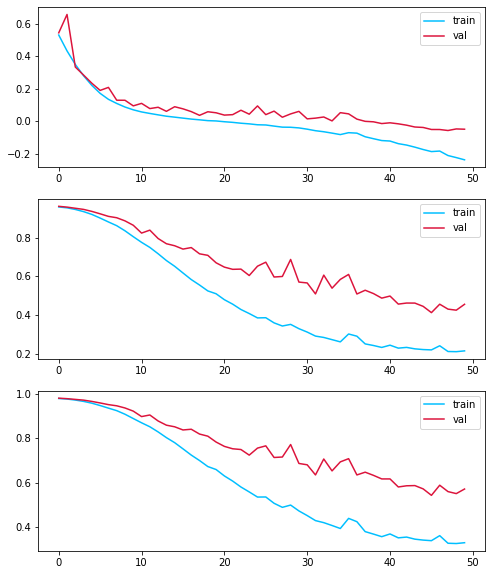

In [22]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
'''
    image shape [1, 4, 155, 80, 80]
    label shape [1, 3, 155, 80, 80]
    in_channels = 4
    n_classes = 3
    out_channels = 32
'''
list_pred = []
model = UNET3D(in_channels=4, out_channels=32, n_classes=3).to(device)    
training(model=model,
            device=device,
            dataset=BratsDataSet,
            path_to_csv=config.train_df,
            epochs=50,
            batch_size=1,
            lr=1e-4,
            amp=False
            )

In [23]:
# len(list_pred)

In [24]:
# list_pred[1].unique

In [25]:
# test = list_pred[1].squeeze().cpu().detach().numpy()

In [26]:
# test = np.moveaxis(test, (0,1,2,3), (0,3,2,1))

In [27]:
# plt.imshow(test[1,:,:,50])

In [28]:
# 

In [29]:
# flair_img = tio.ScalarImage(flair_path)
# # t1_img = tio.ScalarImage(t1_path)
# t1ce_img = tio.ScalarImage(t1ce_path)
# t2_img = tio.ScalarImage(t2_path)
# seg_img = tio.ScalarImage(seg_path)
# flair_img.shape

In [30]:
# crop = tio.CropOrPad((180, 180, 155))
# resample = tio.Resample((2,2,1))

In [31]:
# flair_crop = crop(flair_img)
# flair_crop = resample(flair_crop)

In [32]:
# flair_crop.shape

In [33]:
# flair_crop.plot()

In [34]:
# val_loader = get_dataloader(BratsDataSet,
#                             config.train_df,
#                             phase = 'val',
#                             fold = 0,
#                             batch_size = 1,
#                             num_workers = 4,
#                             transform = transforms('val')
#                            )
                            

In [35]:
# for data in val_loader:
#     image = data['image'][tio.DATA]
#     label = data['label'][tio.DATA]
#     break

In [36]:
# image = np.squeeze(image, 0)
# label = np.squeeze(label, 0)

In [37]:
# image.shape

In [38]:
# image = np.moveaxis(image.numpy(), (0,1,2,3), (0,3,2,1))
# label = np.moveaxis(label.numpy(), (0,1,2,3), (0,3,2,1))

In [39]:
# plt.imshow(image[1,:,:,90])

In [40]:
# plt.imshow(label[0,:,:,90])

In [41]:
# plt.imshow(test[1,:,:,90])

In [42]:
# transformed = transforms('train')(image)

In [43]:
# plt.imshow(transformed[0,:,:,90])

In [44]:
# transformed = transforms('train')(label)

In [45]:
# plt.imshow(transformed[0,:,:,90])